# Análise de decisões judiciais e impacto por grupo de bancos

Este notebook tem como objetivo analisar as decisões judiciais contidas no dataset `acordaos.csv`, buscando entender **a distribuição das decisões favoráveis ou contrárias** aos bancos, bem como **diferenças entre grupos** de instituições (por exemplo, controle, grandes bancos, regionais etc).

A análise seguirá as seguintes etapas:
1. Carregamento e inspeção inicial dos dados.
2. Limpeza e seleção das colunas relevantes.
3. Criação de grupos e categorização.
4. Cálculo das probabilidades de decisão favorável e contrária por grupo.
5. Interpretação dos resultados e visualizações.

## 1️. Carregamento e visualização inicial dos dados

Primeiro, importamos as bibliotecas necessárias e carregamos o arquivo `acordaos.csv`.  
Em seguida, inspecionamos as primeiras linhas para compreender a estrutura do dataset.

In [28]:
import pandas as pd

df = pd.read_csv('acordaos.csv')
df.head(5)

,Unnamed: 0,processo,tipo_processo,data_julgamento,estado,AGRAVANTE,AGRAVADO,RECORRENTE,RECORRIDO,EMBARGANTE,EMBARGADO,AUTOR,REU,INTERESSADO,banco,decisao_para_banco
0,0,1021214/,AGRAVO EM RECURSO ESPECIAL,05/11/2019,NaN,DHJ COMERCIO DE VEICULOS LTDA,ITAU UNIBANCO S.A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ITAU UNIBANCO,indeterminado
1,1,2279744,AGRAVO EM RECURSO ESPECIAL,28/08/2023,SP,EDVALDO FERREIRA DA SILVA,MINISTERIO PUBLICO DO ESTADO DE SAO PAULO; ITA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ITAU UNIBANCO,favoravel
2,2,1079080,AGRAVO EM RECURSO ESPECIAL,24/08/2020,SP,BANCO SANTANDER (BRASIL) S.A.,MARILENE REIS DA SILVA; ROCHA E TOLEDO SERVICO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SANTANDER,contraria
3,3,1101616,AGRAVO EM RECURSO ESPECIAL,21/06/2021,SP,FABIO MARCIO GRAZIOLI,BANCO ALVORADA S.A.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BANCO ALVORADA,favoravel
4,4,1.579.215/,AGRAVO EM RECURSO ESPECIAL,18/02/2020,NaN,QUARTZ-EXPORT ADMINISTRACAO DE INVESTIMENTOS,BANCO BRADESCO S/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRADESCO,contraria


## 2️. Seleção das colunas relevantes e limpeza dos dados

Selecionamos apenas as colunas necessárias à análise — processo, tipo, data de julgamento, estado, banco e decisão.  
Em seguida, removemos registros incompletos (`NaN`) que possam interferir nas contagens.

In [29]:
df_filter = df.loc[:, ['processo', 'tipo_processo', 'data_julgamento', 'estado', 'banco', 'decisao_para_banco']]
df_filter.head(5)

,processo,tipo_processo,data_julgamento,estado,banco,decisao_para_banco
0,1021214/,AGRAVO EM RECURSO ESPECIAL,05/11/2019,NaN,ITAU UNIBANCO,indeterminado
1,2279744,AGRAVO EM RECURSO ESPECIAL,28/08/2023,SP,ITAU UNIBANCO,favoravel
2,1079080,AGRAVO EM RECURSO ESPECIAL,24/08/2020,SP,SANTANDER,contraria
3,1101616,AGRAVO EM RECURSO ESPECIAL,21/06/2021,SP,BANCO ALVORADA,favoravel
4,1.579.215/,AGRAVO EM RECURSO ESPECIAL,18/02/2020,NaN,BRADESCO,contraria


In [30]:
df_filter.dropna(inplace=True)

## 3. Criação dos grupos de bancos

Nesta etapa, agrupamos os bancos conforme sua **origem**, agrupando-os em `nordeste` para processos provindos de estados nordestinos, `sudeste` para processos provindos de estados sudestinos e `controle` para processos provindos de outras regiões.


In [31]:
sigla_grupo = {
    'AC': 'controle',
    'AM': 'controle',
    'AP': 'controle',
    'DF': 'controle',
    'GO': 'controle',
    'MS': 'controle',
    'MT': 'controle',
    'PA': 'controle',
    'PR': 'controle',
    'RO': 'controle',
    'RR': 'controle',
    'RS': 'controle',
    'SC': 'controle',
    'TO': 'controle',
    'ES': 'sudeste',
    'MG': 'sudeste',
    'RJ': 'sudeste',
    'SP': 'sudeste',
    'AL': 'nordeste',
    'BA': 'nordeste',
    'CE': 'nordeste',
    'MA': 'nordeste',
    'PB': 'nordeste',
    'PE': 'nordeste',
    'PI': 'nordeste',
    'RN': 'nordeste',
    'SE': 'nordeste'
}

df_filter['grupo'] = df_filter['estado'].apply(lambda x: sigla_grupo[x] if x in sigla_grupo.keys() else 'controle')
df_filter.head(5)

,processo,tipo_processo,data_julgamento,estado,banco,decisao_para_banco,grupo
1,2279744,AGRAVO EM RECURSO ESPECIAL,28/08/2023,SP,ITAU UNIBANCO,favoravel,sudeste
2,1079080,AGRAVO EM RECURSO ESPECIAL,24/08/2020,SP,SANTANDER,contraria,sudeste
3,1101616,AGRAVO EM RECURSO ESPECIAL,21/06/2021,SP,BANCO ALVORADA,favoravel,sudeste
5,1135110,AGRAVO EM RECURSO ESPECIAL,04/12/2023,RS,BRADESCO,favoravel,controle
6,1155639,AGRAVO EM RECURSO ESPECIAL,23/08/2021,SP,SANTANDER,contraria,sudeste


## 4️. Distribuição das decisões por grupo

Geramos um gráfico de barras empilhadas para visualizar a **proporção de decisões favoráveis e contrárias** em cada grupo de bancos.  
Essa visualização ajuda a identificar diferenças iniciais de tendência entre grupos.


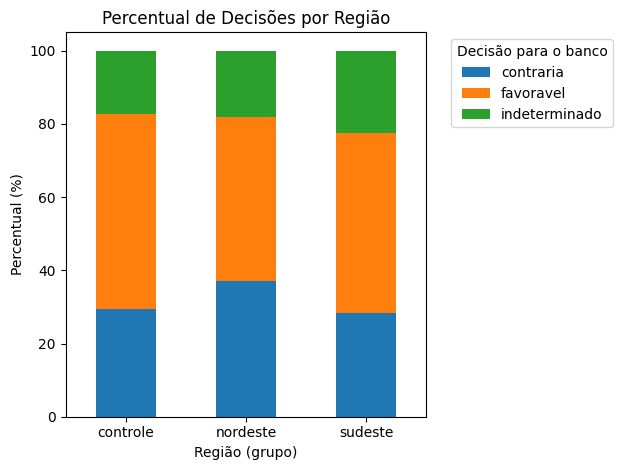

In [32]:
import matplotlib.pyplot as plt

# Agrupar e contar decisões por região (grupo)
contagem = df_filter.groupby(['grupo', 'decisao_para_banco']).size().unstack(fill_value=0)

# Normalizar (converter em percentuais por linha)
percentuais = contagem.div(contagem.sum(axis=1), axis=0) * 100

# Plotar gráfico de barras empilhadas (percentuais)
percentuais.plot(kind='bar', stacked=True)

plt.title('Percentual de Decisões por Região')
plt.xlabel('Região (grupo)')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=0)
plt.legend(title='Decisão para o banco', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

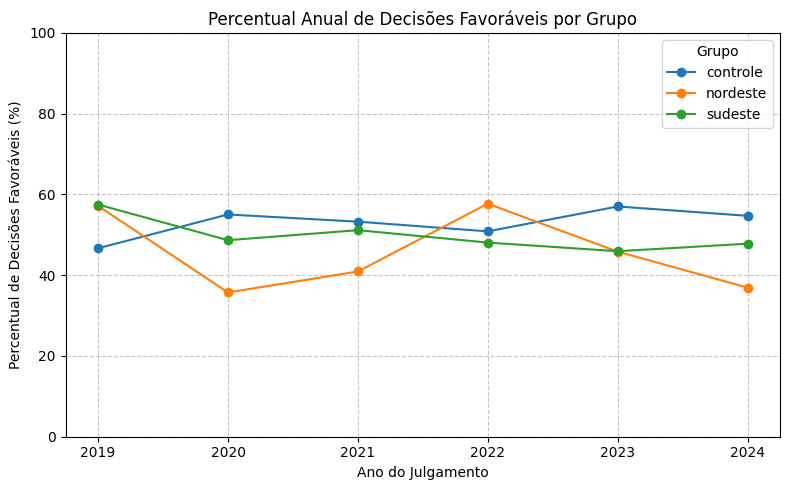

In [33]:
# Converter a data para datetime e extrair o ano
df_filter['data_julgamento'] = pd.to_datetime(df_filter['data_julgamento'], format='%d/%m/%Y')
df_filter['ano'] = df_filter['data_julgamento'].dt.year
df_filter = df_filter[df_filter['ano'] >= 2019]

# Contagem total de decisões por ano e grupo
totais = (
    df_filter.groupby(['ano', 'grupo'])
    .size()
    .reset_index(name='total_decisoes')
)

# Contagem de decisões favoráveis por ano e grupo
favoraveis = (
    df_filter[df_filter['decisao_para_banco'] == 'favoravel']
    .groupby(['ano', 'grupo'])
    .size()
    .reset_index(name='decisoes_favoraveis')
)

# Juntar as duas contagens
df_perc = pd.merge(totais, favoraveis, on=['ano', 'grupo'], how='left')

# Calcular porcentagem de decisões favoráveis
df_perc['perc_favoravel'] = (
    df_perc['decisoes_favoraveis'] / df_perc['total_decisoes'] * 100
).fillna(0)

# Plotar gráfico
plt.figure(figsize=(8, 5))
for grupo, data_grupo in df_perc.groupby('grupo'):
    plt.plot(data_grupo['ano'], data_grupo['perc_favoravel'], marker='o', label=grupo)

plt.title('Percentual Anual de Decisões Favoráveis por Grupo')
plt.xlabel('Ano do Julgamento')
plt.ylabel('Percentual de Decisões Favoráveis (%)')
plt.ylim(0, 100)
plt.legend(title='Grupo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Aplicação de modelos estatísticos

Após compreender as proporções de decisões favoráveis por grupo, é importante verificar **se as diferenças observadas são estatisticamente significativas**.

Para isso, aplicamos **modelos de regressão logística**, nos quais a variável dependente (alvo) é binária:
- `1` se a decisão foi favorável ao banco;
- `0` caso contrário.

O objetivo é estimar a **influência das variáveis explicativas** (como `grupo`, `ano`, etc.) sobre a probabilidade de decisão favorável.


### 5.1 Modelo de regressão logística (scikit-learn)

Usamos o modelo `LogisticRegression` da biblioteca `scikit-learn` para prever o desfecho das decisões.  
Esse modelo estima a **probabilidade de decisão favorável** em função das variáveis explicativas.

Após o ajuste, avaliamos as métricas de desempenho (precisão, recall, F1-score) para verificar a capacidade preditiva do modelo sobre dados de teste.

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Variável alvo binária (1 = favorável, 0 = contrária)
df_filter['alvo'] = (df_filter['decisao_para_banco'] == 'favoravel').astype(int)

# Selecionar variáveis explicativas
X = df_filter[['grupo', 'ano']]
y = df_filter['alvo']

# Codificar variáveis categóricas
categorical_features = ['grupo']
numeric_features = ['ano']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features),
    ],
    remainder='passthrough'
)

# Modelo de regressão logística
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression())
])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Ver importância das variáveis
import numpy as np

# Extrair nomes das variáveis após o OneHotEncoder
feature_names = model.named_steps['preprocess'].get_feature_names_out()
coef = model.named_steps['classifier'].coef_[0]

importance = pd.DataFrame({
    'variavel': feature_names,
    'coeficiente': coef
}).sort_values(by='coeficiente', ascending=False)

print("\nImportância das variáveis (coeficientes da regressão):")
print(importance)

              precision    recall  f1-score   support

           0       0.49      0.59      0.53       357
           1       0.55      0.45      0.50       401

    accuracy                           0.52       758
   macro avg       0.52      0.52      0.52       758
weighted avg       0.52      0.52      0.51       758


Importância das variáveis (coeficientes da regressão):
              variavel  coeficiente
2       remainder__ano     0.000053
1   cat__grupo_sudeste    -0.168369
0  cat__grupo_nordeste    -0.504996


### 5.2 Modelo de significância (statsmodels)

Enquanto o modelo do `scikit-learn` avalia a performance preditiva, a biblioteca `statsmodels` permite estimar **coeficientes e testes de significância** para cada variável.

Aqui transformamos as variáveis categóricas (`grupo`, `ano`) em variáveis *dummies* e ajustamos uma regressão logística clássica (`Logit`).

Os resultados mostram:
- **coeficiente positivo** → aumenta a chance de decisão favorável;
- **coeficiente negativo** → reduz essa chance;
- **p-value pequeno (geralmente < 0,05)** → indica que o efeito é estatisticamente significativo.


In [35]:
import statsmodels.api as sm
import pandas as pd

# One-hot manual
df_dummies = pd.get_dummies(df_filter[['grupo', 'ano']], drop_first=True)

# Converter tudo explicitamente para float
X = sm.add_constant(df_dummies).astype(float)
y = df_filter['alvo'].astype(float)

modelo = sm.Logit(y, X).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.691173
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   alvo   No. Observations:                 2526
Model:                          Logit   Df Residuals:                     2522
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Oct 2025   Pseudo R-squ.:                0.002732
Time:                        03:09:57   Log-Likelihood:                -1745.9
converged:                       True   LL-Null:                       -1750.7
Covariance Type:            nonrobust   LLR p-value:                   0.02263
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             43.1169     51.147      0.843      0.399     -57.129     143.363
ano              

## 6. Cálculo das probabilidades de decisão favorável por grupo

Agora, calculamos diretamente as **probabilidades** de uma decisão ser favorável ou contrária a um banco, de acordo com o **grupo ao qual ele pertence**.  

A tabela a seguir mostra, para cada grupo:
- número total de decisões (`n_total`);
- número e proporção de decisões favoráveis (`n_favorable`, `p_favorable`);
- número e proporção de decisões contrárias (`n_unfavorable`, `p_unfavorable`).

In [38]:
df_use = df_filter.copy()

# Define o que é uma decisão favorável
def is_favorable(x):
    if pd.isna(x):
        return False
    sx = str(x).strip().lower()
    return sx in ('favoravel', 'favorável', 'procedente', 'aprovado', 'sim', 'positivo', 'concedido')

# Marca as decisões favoráveis
df_use['_favorable'] = df_use['decisao_para_banco'].apply(is_favorable)

# Agrupa por grupo e calcula proporções
grouped = (
    df_use
    .groupby('grupo')['_favorable']
    .agg(
        n_favorable='sum',
        n_total='count'
    )
    .reset_index()
)

# Calcula probabilidades
grouped['p_favorable'] = grouped['n_favorable'] / grouped['n_total']
grouped['n_unfavorable'] = grouped['n_total'] - grouped['n_favorable']
grouped['p_unfavorable'] = grouped['n_unfavorable'] / grouped['n_total']

# Ordena do grupo mais favorável ao menos
grouped = grouped.sort_values('p_favorable', ascending=False).reset_index(drop=True)

# Mostra a tabela final
display(grouped)

,grupo,n_favorable,n_total,p_favorable,n_unfavorable,p_unfavorable
0,controle,588,1099,0.535032,511,0.464968
1,sudeste,603,1224,0.492647,621,0.507353
2,nordeste,88,203,0.433498,115,0.566502
